#### Analysis to do in one dataset

For each model, analyze if more components lead to a better performance.

For each model, and each number of components analyze which DR method leads to a better performance.

For each type of model, analyze 


#### Extra analysis

Compare the behavior of each experiment with and without class balancing. 

# Imports

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
# import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import f_oneway
from scipy.stats import ttest_ind, ttest_rel

# Loading Results and Preparing DataFrame

In [5]:


dict_results = {}
for ds in ['Salinas', 'IndianPines']:
    for dr_method in ['PCA', 'FastICA', 'UMAP', 'DiffMaps', 'SOM', 'Corr', 'Var']:
        for n_components in [8, 15, 30]:
            for model in ['mou', 'hamida', 'li', 'paoletti']:
                filename = f'{ds}_{dr_method}_{n_components}_{model}_30epochs.csv'
                print('\n' + filename)

                try:
                    df = pd.read_csv(f'./Results/Not Balanced/{model}/{filename}', index_col=0)
                    # df = pd.read_csv(f'./Results/Class Balancing/{model}/{filename}', index_col=0)

                    print('Loaded.')
                    try:
                        df['Confusion matrix'] = df['Confusion matrix'].apply(lambda x: pickle.loads(eval(x)))
                        df['F1 scores'] = df['F1 scores'].apply(lambda x: pickle.loads(eval(x)))
                        df['IOU'] = df['IOU'].apply(lambda x: pickle.loads(eval(x)))
                        dict_results[f'{ds}_{dr_method}_{n_components}_{model}'] = df
                        print('Columns unpickled.')
                    except:
                        print("Problem with pickled columns")
                except:
                    print("Couldn't find CSV file.")
                
dfs = []
for key, value in dict_results.items():
    df = pd.DataFrame(value)
    df.insert(0, 'Experiment', key)  # Inserting the 'Method' column as the first column
    dfs.append(df)

# Concatenate all DataFrames
df_results = pd.concat(dfs, ignore_index=True)
df_results['Dataset'] = df_results['Experiment'].apply(lambda x: x.split('_')[0])
df_results['DR Method'] = df_results['Experiment'].apply(lambda x: x.split('_')[1])
df_results['N Components'] = df_results['Experiment'].apply(lambda x: int(x.split('_')[2]))
df_results['Model'] = df_results['Experiment'].apply(lambda x: '_'.join(x.split('_')[3:]))
df_results


Salinas_PCA_8_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_8_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_8_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_8_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Sal

,Experiment,Confusion matrix,Accuracy,F1 scores,Kappa,IOU,Dataset,DR Method,N Components,Model
0,Salinas_PCA_8_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.285337,"[0.0, 0.9757838388988019, 1.0, 0.9977266986612...",0.947651,"[0.0, 0.9527127924340468, 1.0, 0.9954637096774...",Salinas,PCA,8,mou
1,Salinas_PCA_8_hamida,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",94.708936,"[0.0, 0.9757838388988019, 1.0, 0.9992414664981...",0.941174,"[0.0, 0.9527127924340468, 1.0, 0.9984840828701...",Salinas,PCA,8,hamida
2,Salinas_PCA_8_li,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.701011,"[0.0, 0.9757838388988019, 1.0, 0.9997470275739...",0.952256,"[0.0, 0.9527127924340468, 1.0, 0.9994941831057...",Salinas,PCA,8,li
3,Salinas_PCA_8_paoletti,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.536589,"[0.0, 0.9757838388988019, 1.0, 0.9929149797570...",0.950400,"[0.0, 0.9527127924340468, 1.0, 0.9859296482412...",Salinas,PCA,8,paoletti
4,Salinas_PCA_15_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",88.488611,"[0.0, 0.9612202688728024, 0.9907914053116241, ...",0.872189,"[0.0, 0.925335988053758, 0.9817508595609628, 0...",Salinas,PCA,15,mou
...,...,...,...,...,...,...,...,...,...,...
163,IndianPines_Var_15_paoletti,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",85.845373,"[0.0, 0.9, 0.8156052017339113, 0.7440970006381...",0.838370,"[0.0, 0.8181818181818182, 0.6886261261261262, ...",IndianPines,Var,15,paoletti
164,IndianPines_Var_30_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",85.884420,"[0.0, 0.8674698795180723, 0.812807881773399, 0...",0.839210,"[0.0, 0.7659574468085106, 0.6846473029045643, ...",IndianPines,Var,30,mou
165,IndianPines_Var_30_hamida,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",96.807888,"[0.0, 1.0, 0.9866666666666667, 0.9402795425667...",0.963690,"[0.0, 1.0, 0.9736842105263158, 0.8872901678657...",IndianPines,Var,30,hamida
166,IndianPines_Var_30_li,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",90.999610,"[0.0, 0.989010989010989, 0.8894247330347916, 0...",0.897302,"[0.0, 0.9782608695652174, 0.8008684863523573, ...",IndianPines,Var,30,li


In [9]:
df_to_save = df_results.copy()
df_to_save['Confusion matrix'] = df_to_save['Confusion matrix'].apply(lambda x: pickle.dumps(x))
df_to_save['F1 scores'] = df_to_save['F1 scores'].apply(lambda x: pickle.dumps(x))
df_to_save['IOU'] = df_to_save['IOU'].apply(lambda x: pickle.dumps(x))
df_to_save.to_csv('exp_results.csv')

In [22]:
df_to_save[['Experiment', 'Accuracy', 'Dataset', 'DR Method', 'N Components', 'Model']].to_csv('exp_accuracy.csv', index=False)

## Functions and Labels

In [10]:
LABELS = {
    "Salinas": [
        "Undefined",
        "Brocoli_green_weeds_1",
        "Brocoli_green_weeds_2",
        "Fallow",
        "Fallow_rough_plow",
        "Fallow_smooth",
        "Stubble",
        "Celery",
        "Grapes_untrained",
        "Soil_vinyard_develop",
        "Corn_senesced_green_weeds",
        "Lettuce_romaine_4wk",
        "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk",
        "Lettuce_romaine_7wk",
        "Vinyard_untrained",
        "Vinyard_vertical_trellis",
    ],

    'IndianPines': [
        "Undefined",
        "Alfalfa",
        "Corn-notill",
        "Corn-mintill",
        "Corn",
        "Grass-pasture",
        "Grass-trees",
        "Grass-pasture-mowed",
        "Hay-windrowed",
        "Oats",
        "Soybean-notill",
        "Soybean-mintill",
        "Soybean-clean",
        "Wheat",
        "Woods",
        "Buildings-Grass-Trees-Drives",
        "Stone-Steel-Towers",
    ]}


def filter_exp_by_substring(df, substrings):
    mask = df['Experiment'].apply(lambda x: any(substring in x for substring in substrings))
    filtered_df = df[mask]
    return filtered_df

# def show_confusion_matrix(confusion_matrix, labels, normalize=False):
#     if normalize:
#         confusion_matrix = normalize_confusion_matrix(confusion_matrix)

#     fig = px.imshow(confusion_matrix, text_auto=True, 
#                     labels=dict(x='Predicted labels', y='Actual labels', color='# of classification'),
#                     x = labels,
#                     y = labels,
#                     height=700
#                     )
#     fig.update_xaxes(tickangle=45, type='category')
#     fig.show()

def show_confusion_matrix(confusion_matrix, labels, normalize=False):
    if normalize:
        confusion_matrix = normalize_confusion_matrix(confusion_matrix)

    fig = go.Figure()

    fig.add_trace(
        go.Heatmap(z=confusion_matrix,  
                   colorscale='Blues', 
                   showscale=False,
                   x=labels, 
                   y=labels,  
                   zmin=0, 
                   zmax=1 if normalize else None,
                   colorbar=dict(title='Normalized' if normalize else 'Counts'))
    )

    fig.update_xaxes(title='Predicted labels', tickangle=45, type='category')
    fig.update_yaxes(title='Actual labels', type='category')

    fig.update_layout(
        title='Confusion Matrix',
        height=800,
        width=800,
        showlegend=False
    )

    fig.show()



def show_confusion_matrices(df_results, exps, labels, normalize=False):
    confusion_matrices = []
    for exp in exps:
        confusion_matrices.append(df_results[df_results['Experiment'] == exp]['Confusion matrix'].values[0])

    fig = make_subplots(rows=2, cols=2, subplot_titles=exps)

    for i, (confusion_matrix, label) in enumerate(zip(confusion_matrices, labels)):
        if normalize:
            confusion_matrix = normalize_confusion_matrix(confusion_matrix)

        row = i // 2 + 1
        col = i % 2 + 1

        fig.add_trace(
            go.Heatmap(z=confusion_matrix, colorscale='Blues', showscale=False,
                       x=labels, y=labels, zmin=0, zmax=1 if normalize else None,
                       colorbar=dict(title='Normalized' if normalize else 'Counts')),
            row=row, col=col
        )

        # fig.update_xaxes(tickangle=45, type='category', row=row, col=col)
        # if col == 2:  # Only update y-axis for the second subplot
        #     fig.update_yaxes(showticklabels=False, row=row, col=col)

        if row == 2:
            fig.update_xaxes(title='Predicted labels', tickangle=45, type='category', row=row, col=col)
        else:
            fig.update_xaxes(showticklabels=False, row=row, col=col)
        
        if col == 1:
            fig.update_yaxes(title='Actual labels', type='category', row=row, col=col)
        else:
            fig.update_yaxes(showticklabels=False, row=row, col=col)
    
    fig.update_layout(
        title='Confusion Matrices',
        height=1000,
        width=1000,
        showlegend=False
    )

    fig.show()


def normalize_confusion_matrix(conf_matrix):
    class_totals = np.sum(conf_matrix, axis=1)
    normalized_conf_matrix = conf_matrix / class_totals[:, np.newaxis]
    return np.round(normalized_conf_matrix, 2)


def plot_acc_by_model(df):
    # Parse 'Experiment' column to extract model information
    df['Model'] = df['Experiment'].apply(lambda x: x.split('_')[-1])
    unique_models = df['Model'].unique()

    colors = px.colors.qualitative.Plotly[:len(unique_models)]

    data = []
    for model, color in zip(unique_models, colors):
        model_data = df[df['Model'] == model]
        trace = go.Bar(
            x=model_data['Experiment'],  
            y=model_data['Accuracy'], 
            name=model, 
            marker=dict(color=color) 
        )
        data.append(trace)

    fig = go.Figure(data=data)

    fig.update_layout(
        title='Accuracies of Different Models',
        xaxis=dict(title='Experiment'),
        yaxis=dict(title='Accuracy (%)', range=[0, 100]),  
        barmode='group',  
        # template='plotly_white'  # White background template
    )

    fig.update_layout(showlegend=True)
    fig.show()


def plot_grouped_values(df_results, labels, metric):
    traces = []
    for i, experiment in enumerate(df_results['Experiment']):
        experiment_iou = df_results[metric].values[i]
        trace = go.Bar(
            x=labels,  
            y=experiment_iou, 
            name=experiment  
        )
        traces.append(trace)

    layout = go.Layout(
        title=f'{metric} Values by Experiment',
        xaxis=dict(title='Class'),
        yaxis=dict(title=metric),
        barmode='group'  # Grouped bars
    )

    fig = go.Figure(data=traces, layout=layout)
    fig.show()


def accuracies_by_n_comps(df, dataset, dr_method):
    accuracy_df = filter_exp_by_substring(df, [f'{dataset}_{dr_method}_'])[['N Components', 'Model', 'Accuracy']]

    accuracy_df = accuracy_df.pivot(index='Model', columns='N Components', values='Accuracy')
    accuracy_df.__doc__ = f"Accuracy values in {dataset} using {dr_method}"
    return accuracy_df


def ANOVA_TTest(df_accuracies, transposed=False, describe=False, ind_samples=False):
    if transposed:
        df_accuracies = df_accuracies.transpose()
    
    print(df_accuracies)
    if describe:
        print(df_accuracies.describe().loc[['mean', 'std', 'max']])    

    # Perform ANOVA
    f_statistic, p_value = f_oneway(*df_accuracies.values)
    print(f'ANOVA test -> F-statistic: {f_statistic}, p-value: {p_value}')

    if p_value < 0.05:
        print("The ANOVA test INDICATES that there is a significant difference in accuracies.")
    # else:
    #     print("The ANOVA test DOES NOT INDICATE a significant difference in accuracies.")

    print('\nPaired T Tests')

    # Perform paired t-tests
    found = False
    differences = []
    for i in range(len(df_accuracies)):
        for j in range(i+1, len(df_accuracies)):
            data1 = df_accuracies.iloc[i]
            data2 = df_accuracies.iloc[j]
            if ind_samples:
                t_statistic, p_value = ttest_rel(data1, data2)
            else:
                t_statistic, p_value = ttest_rel(data1, data2)
            print(f"\n{df_accuracies.index[i]} vs {df_accuracies.index[j]}: t-statistic = {t_statistic}, p-value = {p_value}")
            if p_value < 0.05:
                found = True
                if data1.mean() > data2.mean():
                    difference = f"THERE IS A SIGNIFICANT DIFFERENCE in accuracies in favor of {df_accuracies.index[i]} over {df_accuracies.index[j]}."
                    # print(difference)
                    differences.append(f'{df_accuracies.index[i]} > {df_accuracies.index[j]}')
                else:
                    difference = f"THERE IS A SIGNIFICANT DIFFERENCE in accuracies in favor of {df_accuracies.index[j]} over {df_accuracies.index[i]}."
                    # print(difference)
                    differences.append(f'{df_accuracies.index[j]} > {df_accuracies.index[i]}')

            # else:
                # print(f"There is NO SIGNIFICANT DIFFERENCE in accuracies between {df_accuracies.index[i]} and {df_accuracies.index[j]}.")
    if differences == []:
        print("\nNo significant difference found with T Tests")
    return differences

def paired_t_test(df_accuracies):
 # Perform paired t-tests
    found = False
    differences = []

    data1 = df_accuracies.iloc[0]
    data2 = df_accuracies.iloc[1]
    t_statistic, p_value = ttest_rel(data1, data2)
    # print(f"\n{df_accuracies.index[0]} vs {df_accuracies.index[1]}: t-statistic = {t_statistic}, p-value = {p_value}")
    if p_value < 0.05:
        found = True
        if data1.mean() > data2.mean():
            return df_accuracies.iloc[0].name
        else:
            return df_accuracies.iloc[1].name
    return '='


def scores_by_model(df, dataset, dr_method, n_comps, scores):
    if scores == 'F1':
        scores_df = filter_exp_by_substring(df, [f'{dataset}_{dr_method}_'])[['N Components', 'Model', 'F1 scores']]
        scores_df = scores_df.pivot(index='Model', columns='N Components', values='F1 scores')
    elif scores == 'IOU':
        scores_df = filter_exp_by_substring(df, [f'{dataset}_{dr_method}_'])[['N Components', 'Model', 'IOU']]
        scores_df = scores_df.pivot(index='Model', columns='N Components', values='IOU')

    scores_df.__doc__ = f"{scores} scores values in {dataset} using {dr_method}"

    df_flat = pd.concat([scores_df[n_comps], scores_df[n_comps].apply(pd.Series)], axis=1)
    df_flat.drop(columns=[n_comps], inplace=True)
    df_flat.columns = [f'Class {i+1}' for i in range(len(df_flat.columns))]
    
    return df_flat


import seaborn as sns
import matplotlib.pyplot as plt

def plot_sorted_column_heatmap(df, column_name):
    """
    Plot a specified column of a DataFrame as a heatmap, sorted by another column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot as a heatmap.
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Sort the DataFrame by the specified column
    df_sorted = df.sort_values(by=column_name, ascending=False)
    
    # Create the heatmap
    plt.figure(figsize=(1, 8))  # Adjust figsize as necessary
    sns.heatmap(df_sorted[[column_name]], cmap='Spectral', cbar=False, annot=True, vmin=0, vmax=100)
    
    # Set y-axis labels to the experiment names
    plt.yticks(ticks=np.arange(df_sorted.shape[0]) + 0.5, labels=df_sorted['Experiment'], rotation=0)  # Use shape[0] for the number of rows
    
    # Set plot labels and title
    plt.ylabel('Experiment')
    plt.title(f'{column_name}')
    plt.show()




In [16]:
ds = 'IndianPines'
df_ds = df_results[df_results['Dataset'] == ds].copy()

# Expand 'IOU' lists into separate columns using class names
iou_df = pd.DataFrame(df_ds['IOU'].tolist(), columns=LABELS[ds])

# Concatenate expanded columns with the original DataFrame
experiments_IOU = pd.concat([df_ds.drop(columns=['IOU']), iou_df], axis=1)

# Unpivot (melt) the DataFrame to have 'Class' and 'IoU Score' as columns
experiments_IOU_melted = experiments_IOU.melt(
    id_vars=['Experiment', 'Accuracy', 'Kappa', 'Dataset', 'DR Method', 'N Components', 'Model'],
    value_vars=LABELS[ds],
    var_name='Class',
    value_name='IoU Score'
)

# Export to CSV
experiments_IOU_melted.to_csv(f'exp_{ds}_with_iou_melted.csv', index=False)

# Display the resulting DataFrame
experiments_IOU_melted

,Experiment,Accuracy,Kappa,Dataset,DR Method,N Components,Model,Class,IoU Score
0,IndianPines_PCA_8_mou,92.786021,0.917880,IndianPines,PCA,8.0,mou,Undefined,NaN
1,IndianPines_PCA_8_hamida,97.120266,0.967257,IndianPines,PCA,8.0,hamida,Undefined,NaN
2,IndianPines_PCA_8_li,97.393596,0.970370,IndianPines,PCA,8.0,li,Undefined,NaN
3,IndianPines_PCA_8_paoletti,95.616947,0.950204,IndianPines,PCA,8.0,paoletti,Undefined,NaN
4,IndianPines_PCA_15_mou,80.534947,0.778632,IndianPines,PCA,15.0,mou,Undefined,NaN
...,...,...,...,...,...,...,...,...,...
2851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,0.957895
2852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,0.978947
2853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,1.000000
2854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,0.978723


# CONFUSION MATRICES

NO CLASS BALANCING:
- Salinas_PCA: OK for all models and n_comps
- Salinas_FastICA: 
    - CNNs performed well except for LI NOT CONVERGING with 15 and 30 components
    - RNNs peformed well except for MOU NOT CONVERGING with 30 components
- IndianPines_PCA: 
    - CNNs presented slightly worse reults with 8 components. Also, LI NOT CONVERGING with 30 components
    - RNNs presented very poor results with any number of components. 

- IndianPines_FastICA:
    - CNNs presented slightly better results than with PCA. 
    - RNNs presented much better results than with PCA. 

In [11]:

# dr = 'PCA'
dr = 'UMAP'

n_comps = 8
exps = [
    f'{ds}_{dr}_{n_comps}_li',
    f'{ds}_{dr}_{n_comps}_hamida',
    f'{ds}_{dr}_{n_comps}_mou',
    f'{ds}_{dr}_{n_comps}_paoletti'
]
show_confusion_matrices(df_results, exps, labels=LABELS[ds], normalize=True)

n_comps = 15
exps = [
    f'{ds}_{dr}_{n_comps}_li',
    f'{ds}_{dr}_{n_comps}_hamida',
    f'{ds}_{dr}_{n_comps}_mou',
    f'{ds}_{dr}_{n_comps}_paoletti'
]
show_confusion_matrices(df_results, exps, labels=LABELS[ds], normalize=True)

n_comps = 30
exps = [
    f'{ds}_{dr}_{n_comps}_li',
    f'{ds}_{dr}_{n_comps}_hamida',
    f'{ds}_{dr}_{n_comps}_mou',
    f'{ds}_{dr}_{n_comps}_paoletti'
]
show_confusion_matrices(df_results, exps, labels=LABELS[ds], normalize=True)


C:\Users\Dell\AppData\Local\Temp\ipykernel_11840\3497796932.py:139: RuntimeWarning:

invalid value encountered in divide



# ACCURACIES

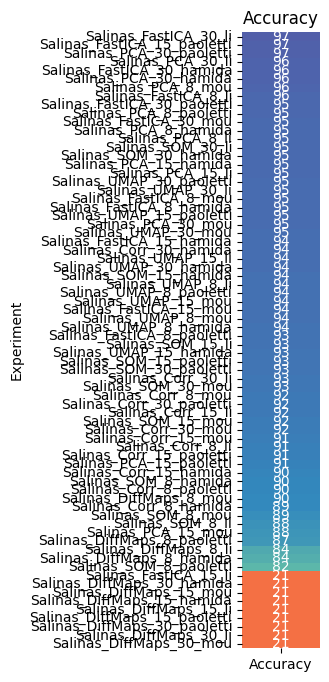

In [12]:
plot_sorted_column_heatmap(df_results[(df_results['Dataset'] == ds)], 'Accuracy')
# dr = 'PCA'
# plot_sorted_column_heatmap(df_results[(df_results['Dataset'] == ds) & (df_results['DR Method'] == dr)],'Accuracy') 

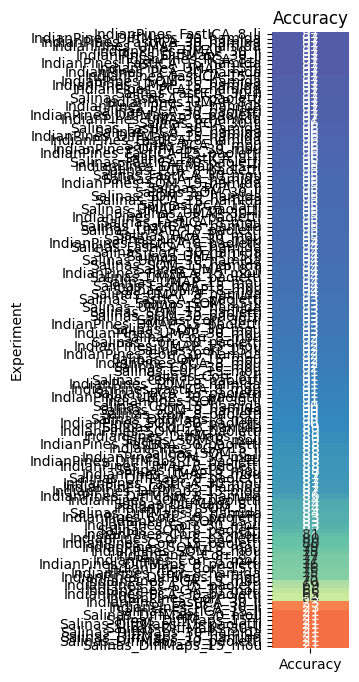

In [13]:
plot_sorted_column_heatmap(df_results,'Accuracy') 

In [14]:
# ds = 'Salinas'
# dr = 'FastICA'
plot_acc_by_model(filter_exp_by_substring(df_results, [f'{ds}_{dr}_8']))


C:\Users\Dell\AppData\Local\Temp\ipykernel_11840\3497796932.py:145: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# ds = 'Salinas'
n_comps = 30

plot_acc_by_model(df_results[(df_results['Dataset'] == ds) ])
                # & (df_results['N Components'] == n_comps)])

## F1 SCORES

In [ ]:
# ds = 'Salinas'
# dr = 'PCA'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)], 
                LABELS[ds],
                metric='F1 scores')

In [ ]:
ds = 'Salinas'
dr = 'PCA'
model = 'mou'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)
                & (df_results['Model'] ==  model)], 
                LABELS[ds],
                metric='F1 scores')

## IOU SCORES

In [ ]:
ds = 'Salinas'
dr = 'FastICA'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)], 
                LABELS[ds],
                metric='IOU')
dr = 'PCA'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)], 
                LABELS[ds],
                metric='IOU')

In [ ]:
ds = 'Salinas'
dr = 'PCA'
model = 'li'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)
                & (df_results['Model'] ==  model)], 
                LABELS[ds],
                metric='IOU')


# ANOVA

In [1]:
ds = 'IndianPines'
dr = 'FastICA'

accuracies = accuracies_by_n_comps(df_results, ds, dr)

ANOVA_TTest(accuracies, 
            transposed=False, 
            describe=False, 
            ind_samples=False)
# ANOVA_TTest(accuracies, transposed=True)

NameError: name 'accuracies_by_n_comps' is not defined

In [ ]:
scores_df = scores_by_model(df_results, #[df_results['Model'].isin(['mou', 'paoletti'])], 
                            dataset=ds, 
                            dr_method=dr, 
                            n_comps=15,
                            scores='IOU')
ANOVA_TTest(scores_df, transposed=False)

KeyError: 15

# Statistical Inference with Paired T-Tests


## Compare models with the same architecture, different sizes

In [ ]:
metric = 'IOU'

for ds in ['Salinas', 'IndianPines']:
    for paired_models in [['mou', 'paoletti'], ['li', 'hamida']]:
        df_ttest = pd.DataFrame(columns=[8, 15, 30])
        print(f'\n{paired_models[0]} vs {paired_models[1]} - {metric} in {ds}')
        for dr_method in ['PCA', 'FastICA', 'UMAP', 'SOM', 'DiffMaps', 'Corr']:
            diffs = []
            for n_comps in [8, 15, 30]:
                scores_df = scores_by_model(df_results[df_results['Model'].isin(paired_models)], 
                                            dataset=ds, 
                                            dr_method=dr_method, 
                                            n_comps=n_comps,
                                            scores=metric)
                
                diffs.append(paired_t_test(scores_df))
            df_ttest.loc[dr_method] = diffs
        print(df_ttest)





mou vs paoletti - IOU in Salinas


KeyError: 8

Comparing models with different architectures, but "same" size

In [ ]:
metric = 'IOU'

for ds in ['Salinas', 'IndianPines']:
    for paired_models in [['hamida', 'paoletti'], ['li', 'mou']]:
        df_ttest = pd.DataFrame(columns=[8, 15, 30])
        print(f'\n{paired_models[0]} vs {paired_models[1]} - {metric} in {ds}')
        for dr_method in ['PCA', 'FastICA']:
            diffs = []
            for n_comps in [8, 15, 30]:
                scores_df = scores_by_model(df_results[df_results['Model'].isin(paired_models)], 
                                            dataset=ds, 
                                            dr_method=dr_method, 
                                            n_comps=n_comps,
                                            scores=metric)
                
                diffs.append(paired_t_test(scores_df))
            df_ttest.loc[dr_method] = diffs
        print(df_ttest)





hamida vs paoletti - IOU in Salinas
             8         15      30
PCA      hamida    hamida  hamida
FastICA       =  paoletti  hamida

li vs mou - IOU in Salinas
         8    15  30
PCA      li   li  li
FastICA   =  mou   =

hamida vs paoletti - IOU in IndianPines
             8       15      30
PCA      hamida  hamida  hamida
FastICA  hamida  hamida  hamida

li vs mou - IOU in IndianPines
         8   15   30
PCA      li  li  mou
FastICA  li  li  mou


In [ ]:
ds = 'Salinas'
dr = 'PCA'
n_comps=30
metric = 'IOU'

scores_df = scores_by_model(df_results[df_results['Model'].isin(['li', 'hamida'])], 
                            dataset=ds, 
                            dr_method=dr, 
                            n_comps=n_comps,
                            scores=metric)
scores_df['Mean'] = scores_df.agg('mean', axis=1).values
scores_df

,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,Class 10,Class 11,Class 12,Class 13,Class 14,Class 15,Class 16,Class 17,Mean
Model,,,,,,,,,,,,,,,,,,
hamida,0.0,0.952713,0.999732,0.998988,0.988555,0.997764,0.984095,0.987709,0.876836,0.994368,0.953600,0.964552,0.968427,0.975983,0.970149,0.806371,0.856669,0.898618
li,0.0,0.952713,1.000000,0.999494,0.992832,0.999627,0.984592,0.987989,0.896274,0.995330,0.966819,0.966324,0.970451,0.975983,0.970121,0.826120,0.860066,0.902631


In [ ]:
accuracies = accuracies_by_n_comps(df_results, ds, dr)
accuracies

N Components,8,15,30
Model,,,
hamida,96.614304,97.346083,97.404625
li,94.175041,97.199727,23.338862
mou,87.423163,93.013953,87.657332
paoletti,89.745341,96.848473,91.911406


# Analyzing classes 

In [ ]:
# df = pd.DataFrame(data=df_results['IOU'])
# df
ds = 'Salinas'

df = df_results[df_results['Dataset']==ds].copy()

df = pd.DataFrame(columns=LABELS[ds], data=[val for val in df['IOU'].values], index=df['Experiment'].values)
# df['exp_mean'] = df.agg('mean', axis=1)


#filter experiments that didn't converge

# df = df[df['exp_mean'] > 0.5]
df

,Undefined,Brocoli_green_weeds_1,Brocoli_green_weeds_2,Fallow,Fallow_rough_plow,Fallow_smooth,Stubble,Celery,Grapes_untrained,Soil_vinyard_develop,Corn_senesced_green_weeds,Lettuce_romaine_4wk,Lettuce_romaine_5wk,Lettuce_romaine_6wk,Lettuce_romaine_7wk,Vinyard_untrained,Vinyard_vertical_trellis
Salinas_PCA_8_mou,0.0,0.978261,0.890293,0.778139,0.777372,0.880325,0.983651,0.866667,0.993750,0.900000,0.872024,0.868360,0.716176,0.980676,0.939117,0.662651,0.968750
Salinas_PCA_8_hamida,0.0,0.947237,0.996522,0.969955,0.987097,0.992584,0.984592,0.987427,0.806308,0.981399,0.909651,0.867925,0.962468,0.973856,0.969245,0.693245,0.855881
Salinas_PCA_8_li,0.0,0.952713,1.000000,0.972713,0.989979,0.996274,0.984592,0.987151,0.796321,0.977328,0.932219,0.855953,0.963955,0.975983,0.970093,0.655603,0.856195
Salinas_PCA_8_paoletti,0.0,0.896852,0.963305,0.867342,0.968436,0.904864,0.984592,0.947866,0.710404,0.962285,0.823934,0.772905,0.932203,0.899796,0.952778,0.624042,0.603328
Salinas_PCA_15_mou,0.0,0.923529,0.977394,0.840789,0.947038,0.875546,0.984592,0.944745,0.693102,0.950352,0.813233,0.672453,0.907579,0.828735,0.935018,0.617453,0.572239
Salinas_PCA_15_hamida,0.0,0.951220,0.999195,0.989383,0.989270,0.995151,0.984343,0.987434,0.859222,0.994528,0.947463,0.943779,0.964451,0.973856,0.970149,0.775839,0.855881
Salinas_PCA_15_li,0.0,0.952713,1.000000,0.994461,0.992120,0.997387,0.984592,0.987713,0.847848,0.995170,0.955428,0.943275,0.967942,0.975983,0.966355,0.758608,0.859436
Salinas_PCA_15_paoletti,0.0,0.792932,0.917757,0.852645,0.973534,0.900111,0.984592,0.942380,0.697958,0.984122,0.847214,0.819835,0.945269,0.849275,0.952250,0.629258,0.587243
Salinas_PCA_30_mou,0.0,0.908412,0.971166,0.855634,0.962062,0.895511,0.984339,0.930164,0.692671,0.936518,0.762850,0.623044,0.885207,0.830189,0.944495,0.605537,0.581505
Salinas_PCA_30_hamida,0.0,0.952713,0.999732,0.998988,0.988555,0.997764,0.984095,0.987709,0.876836,0.994368,0.953600,0.964552,0.968427,0.975983,0.970149,0.806371,0.856669


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

if 'mean' in df.index:
    new_df = df.drop('mean')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(new_df.astype(float), cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('Heatmap of DataFrame')
plt.show()

ValueError: setting an array element with a sequence.

<Figure size 1200x800 with 0 Axes>

# LATEX TABLES

In [ ]:
from tabulate import tabulate

# mou vs paoletti - IOU in Salinas
#                8         15        30
# PCA      paoletti         =  paoletti
# FastICA         =  paoletti  paoletti

# li vs hamida - IOU in Salinas
#         8       15      30
# PCA      =       =      li
# FastICA  =  hamida  hamida

# mou vs paoletti - IOU in IndianPines
#         8         15        30
# PCA      =         =         =
# FastICA  =  paoletti  paoletti

# li vs hamida - IOU in IndianPines
#              8       15      30
# PCA           =  hamida  hamida
# FastICA  hamida  hamida  hamida

# Define the DataFrame data
data = {
    8: ['=', '='],
    15: ['=', 'paoletti'],
    30: ['=', 'paoletti']
}


# Define custom row labels
index = ['PCA', 'FastICA']

# Generate the LaTeX code for the table with centered content
table = tabulate(data, headers='keys', tablefmt='latex_raw', showindex=index)

# Add \centering to center the content of each cell
table = "\\begin{table}[h]\n\\caption{Paired T Test of Mou (Shallow RNN) and Paoletti (Deep RNN) on Indian Pines Dataset}\n\\centering\n" + table + "\n\\end{table}"

# Print the LaTeX code
print(table)

\begin{table}[h]
\caption{Paired T Test of Mou (Shallow RNN) and Paoletti (Deep RNN) on Indian Pines Dataset}
\centering
\begin{tabular}{llll}
\hline
         & 8   & 15       & 30       \\
\hline
 PCA     & =   & =        & =        \\
 FastICA & =   & paoletti & paoletti \\
\hline
\end{tabular}
\end{table}
